<a href="https://colab.research.google.com/github/kotharisanjana/CMPE258_DeepLearning_Spring2023/blob/main/Assignment_3/f_NN_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Write a colab in JAX only from scratch 3 layer deep neural network for non linear regression using low-level and high-level API**

In [105]:
# Imports

import jax
from jax import numpy as jnp
from jax import grad, value_and_grad
from jax.example_libraries import stax, optimizers

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [91]:
# Generate non-linear data

n = 1000
dim = 3
x = np.random.uniform(-1, 1, (n, dim))
print('Input shape =', x.shape)

Input shape = (1000, 3)


In [92]:
# Initialize weights and bias

weights = np.array([[2, -3, 1]]).T
bias = np.array([8])
print('Weights shape =', weights.shape)
print('Bias shape =', bias.shape)

# non-linear 3 variable function we want to learn
y_true = np.einsum('ij, jk -> ik', (x**3),  weights) + np.einsum('ij, jk -> ik', (x**2),  weights) + np.einsum('ij, jk -> ik', x, weights) + bias
print('Function output shape =', y_true.shape)

Weights shape = (3, 1)
Bias shape = (1,)
Function output shape = (1000, 1)


In [118]:
# Hyperparamter initializations

input_dim = dim
output_dim = 1
hidden_dim = 16

learning_rate = 0.01
num_epochs = 50

seed = jax.random.PRNGKey(101)

#### Using low-level API

In [119]:
def initialize_weights(input_dim, output_dim, hidden_dim, seed):
  weights = []

  # Weights for 1st hidden layer
  w = jax.random.uniform(key=seed, shape=(input_dim, hidden_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(hidden_dim,), dtype=jnp.float32)
  weights.append([w,b])

  # Weights for 2nd hidden layer
  w = jax.random.uniform(key=seed, shape=(hidden_dim, hidden_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(hidden_dim,), dtype=jnp.float32)
  weights.append([w,b])

  # Weights for output layer
  w = jax.random.uniform(key=seed, shape=(hidden_dim, output_dim), minval=-1.0, maxval=1.0, dtype=jnp.float32)
  b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(output_dim,), dtype=jnp.float32)
  weights.append([w,b])

  return weights

In [120]:
# Non-linear activation function

def relu(x):
  return jnp.maximum(x, jnp.zeros_like(x))

In [121]:
# Linear layer

def linear(weights, input, activation=lambda x: x):
  weights, bias = weights
  out = jnp.dot(input, weights) + bias
  return activation(out)

In [122]:
# Forward pass

def forward(weights, input):
  layer_out = input

  for i in range(len(weights[:-1])):
    layer_out = linear(weights[i], layer_out, relu)

  preds = linear(weights[-1], layer_out)

  return preds.squeeze()

In [123]:
# Error function - Mean Square Error

def mean_squared_error(weights, input, actual):
    preds = forward(weights, input)
    return jnp.power(actual - preds, 2).mean()

In [124]:
# Computing gradients using JAX grad

def backward(weights, input, actual):
    loss = grad(mean_squared_error)
    gradients = loss(weights, input, actual)
    return gradients

In [125]:
# Train network

def train(weights, x, y_true, learning_rate, num_epochs):
  loss_ =  []

  for epoch in range(num_epochs):
    loss_value = mean_squared_error(weights, x, y_true)
    gradients = backward(weights, x, y_true)

    # Update Weights
    for j in range(len(weights)):
      weights[j][0] -= learning_rate * gradients[j][0] 
      weights[j][1] -= learning_rate * gradients[j][1]

    print(f'Epoch {epoch}, loss {loss_value}')
    loss_.append(loss_value)

  return loss_

In [126]:
# Initialize weights
weights = initialize_weights(input_dim, output_dim, hidden_dim, seed)

# Train model
loss_ = train(weights, x, y_true, learning_rate, num_epochs)

Epoch 0, loss 16.276750564575195
Epoch 1, loss 15.112936973571777
Epoch 2, loss 14.745722770690918
Epoch 3, loss 14.473410606384277
Epoch 4, loss 14.247187614440918
Epoch 5, loss 14.05783462524414
Epoch 6, loss 13.898534774780273
Epoch 7, loss 13.763169288635254
Epoch 8, loss 13.647698402404785
Epoch 9, loss 13.548829078674316
Epoch 10, loss 13.46292781829834
Epoch 11, loss 13.388622283935547
Epoch 12, loss 13.324357986450195
Epoch 13, loss 13.268770217895508
Epoch 14, loss 13.220394134521484
Epoch 15, loss 13.178058624267578
Epoch 16, loss 13.140802383422852
Epoch 17, loss 13.107879638671875
Epoch 18, loss 13.078653335571289
Epoch 19, loss 13.052685737609863
Epoch 20, loss 13.029497146606445
Epoch 21, loss 13.008718490600586
Epoch 22, loss 12.990102767944336
Epoch 23, loss 12.97329330444336
Epoch 24, loss 12.958028793334961
Epoch 25, loss 12.94412612915039
Epoch 26, loss 12.931408882141113
Epoch 27, loss 12.919747352600098
Epoch 28, loss 12.909029006958008
Epoch 29, loss 12.8991756439

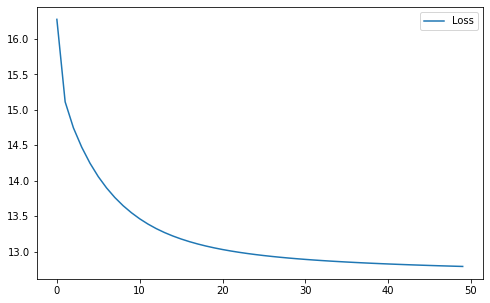

In [127]:
# Plot epoch vs loss

plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_, label='Loss')
plt.legend()

From the plot above, we see that the loss initially goes up but then consistently reduces as the number of epochs increases. This is because the model is learning the underlying function. Backpropagation updates weights and biases so as to minimize the loss which is seen from the 50 epochs above.

#### Using high-level API

In [128]:
# Create 3 layer deep neural network with non-linear activation function

init, apply = stax.serial(stax.Dense(input_dim),
                          stax.Relu,
                          stax.Dense(hidden_dim),
                          stax.Relu,
                          stax.Dense(hidden_dim),
                          stax.Relu,
                          stax.Dense(output_dim),
                          )

In [129]:
# Loss function

def mean_squared_error(weights, input, y_true):
    y_pred = apply(weights, input).squeeze()
    return jnp.power(y_true - y_pred, 2).mean()

In [130]:
# Training neural netwrok method

def train(x, y_true, num_epochs, opt_state):
  loss_ = []

  for epoch in range(num_epochs):
    # Optimizer state is an object that has weights of our model
    loss_value, gradients = value_and_grad(mean_squared_error)(optimizer_get_weights(opt_state), x, y_true)

    # Update Weights
    opt_state = optimizer_update(epoch, gradients, opt_state)

    loss_.append(loss_value)
    print(f'Epoch {epoch}, loss {loss_value}')

  return opt_state, loss_

In [131]:
# Initialize weights by passing input dimensions to init function 

weights = init(seed, (x.shape[1],))
weights = weights[1]

optimizer_init, optimizer_update, optimizer_get_weights = optimizers.sgd(learning_rate)
optimizer_state = optimizer_init(weights)

final_optimizer_state, loss_ = train(x, y_true, num_epochs, optimizer_state)

Epoch 0, loss 79.30587005615234
Epoch 1, loss 74.05699920654297
Epoch 2, loss 68.7133560180664
Epoch 3, loss 62.81413650512695
Epoch 4, loss 56.09819030761719
Epoch 5, loss 48.36458969116211
Epoch 6, loss 39.55276107788086
Epoch 7, loss 30.107898712158203
Epoch 8, loss 21.472415924072266
Epoch 9, loss 15.714240074157715
Epoch 10, loss 13.467304229736328
Epoch 11, loss 13.042821884155273
Epoch 12, loss 12.98958683013916
Epoch 13, loss 12.969024658203125
Epoch 14, loss 12.95152759552002
Epoch 15, loss 12.935443878173828
Epoch 16, loss 12.92066478729248
Epoch 17, loss 12.907354354858398
Epoch 18, loss 12.895045280456543
Epoch 19, loss 12.88361930847168
Epoch 20, loss 12.872958183288574
Epoch 21, loss 12.86299991607666
Epoch 22, loss 12.853693008422852
Epoch 23, loss 12.845001220703125
Epoch 24, loss 12.836832046508789
Epoch 25, loss 12.829174995422363
Epoch 26, loss 12.821949005126953
Epoch 27, loss 12.815129280090332
Epoch 28, loss 12.808708190917969
Epoch 29, loss 12.802633285522461
Epo

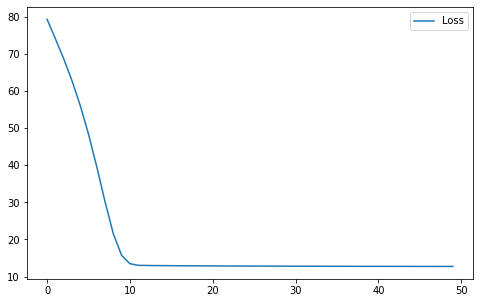

In [132]:
# Plot epoch vs loss

plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_, label='Loss')
plt.legend()

We see a big drop in MSE loss until 10 epochs after which the loss decreases very gradually. The network is taking time to converge which can be addressed using variable learning rate. However, since the loss is reducing, it is positive that the network is learning the underlying function. 